In [170]:
from utils import harris, dist2, find_sift
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import skimage
import numpy as np

# add your imports below
import cv2

## 1. Load images and Convert to grayscale

In [171]:
# read the image
img1 = skimage.io.imread("./uttower_left.jpg")
img2 = skimage.io.imread("./uttower_right.jpg")

# Convert images to float
img1 = img1.astype(np.float32)
img2 = img2.astype(np.float32)

# Convert images to grayscale
img1 = skimage.color.rgb2gray(img1)
img2 = skimage.color.rgb2gray(img2)

## 2. Detect Feature Points

In [172]:
# Parameters for Harris detection
sigma = 2
thresh = 5
radius = 8


In [173]:
# use harris from utils.py
cim1, r1, c1 = harris(img1, sigma, thresh, radius)
cim2, r2, c2 = harris(img2, sigma, thresh, radius)
# print(f"parameters are{cim1} {r1} {c1}")
# print(f"parameters are{cim2} {r2} {c2}")

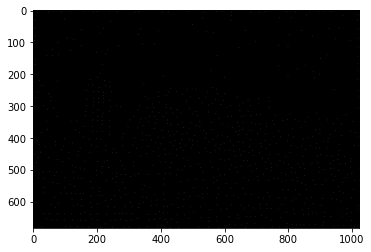

In [174]:
plt.imshow(cim1, cmap='gray')

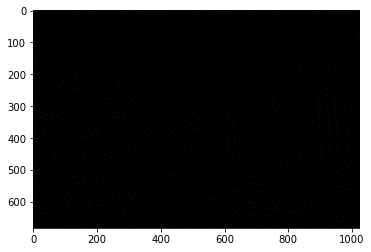

In [175]:
plt.imshow(cim2, cmap='gray')

In [176]:
def draw_corners(img, r, c):
    img_copy = img.copy()
    fig, ax = plt.subplots(figsize = (10, 10))
    for i in range(0, len(r)):
        rect = patches.Rectangle((c[i], r[i]), 10, 10, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    ax.imshow(img_copy, cmap='gray')

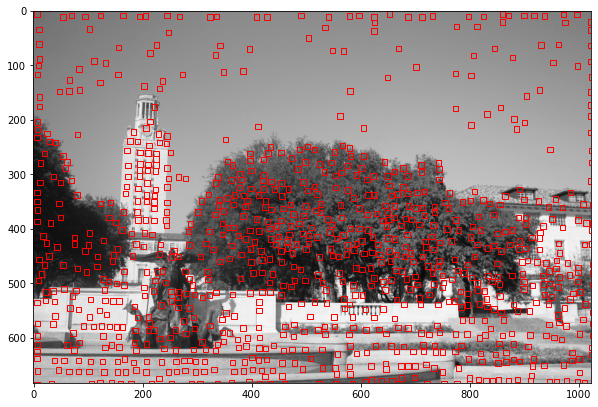

In [177]:
draw_corners(img1, r1, c1)

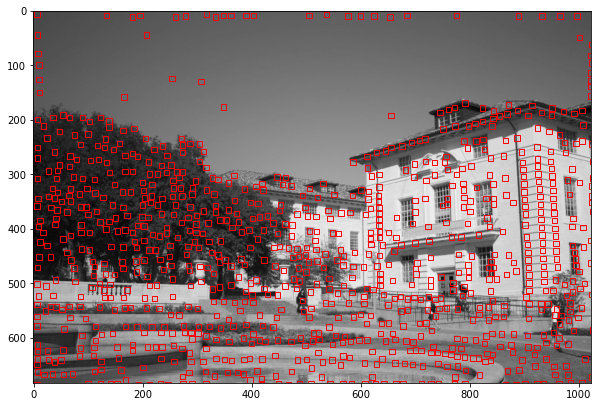

In [178]:
draw_corners(img2, r2, c2)

## 3. Extract local neighborhoods around every keypoint

In [179]:
def neighbor_descriptors(img, r, c, width):
    radius=(width-1)//2
    circles = np.vstack((c, r, np.full_like(c, radius))).T
    return find_sift(img, circles)

In [180]:
radius=7
width = 2 * radius +1
descriptors_1 =neighbor_descriptors(img1, r1, c1, width)
descriptors_2 =neighbor_descriptors(img2, r2, c2, width)
# print(f"descriptors1 are:\n{descriptors_1}")
# print(f"descriptors2 are:\n{descriptors_2}")
# print(f"shape of descriptor1{descriptors_1.shape}, shape of descriptor2:{descriptors_2.shape}")

## 4. Compute distances between descriptors

In [181]:
# use dist2 from utils.py to compute dist between descriptors
distances = dist2(descriptors_1, descriptors_2)

## 5. Select Matches

In [182]:
def filter_descriptors_by_dist(distances, thresh):
    matches = []
    for i in range(distances.shape[0]):
        
        indices = np.argsort(distances[i])
        
        if distances[i, indices[0]] < thresh * distances[i, indices[1]]:
            matches.append((i, indices[0]))
    
    return matches


threshold = 0.8
filtered_matches = filter_descriptors_by_dist(distances, threshold)

In [183]:
print(f"length of all filter matches are:{len(filtered_matches)}")

length of all filter matches are:409


## 6. RANSAC

In [184]:
def compute_homography(pts1, pts2):
    num_points = len(pts1)
    A = np.zeros((2 * num_points, 9))

    for i in range(num_points):
        x, y = pts1[i]
        xp, yp = pts2[i]
        A[2 * i] = [-x, -y, -1, 0, 0, 0, xp * x, xp * y, xp]
        A[2 * i + 1] = [0, 0, 0, -x, -y, -1, yp * x, yp * y, yp]

    U, S, Vt = np.linalg.svd(A)
    H = Vt[-1].reshape(3, 3)
    return H

def RANSAC(filtered_matches, eps, num_loops):
    max_inliers = np.empty((0,), dtype=bool)
    best_H = None

    for _ in range(num_loops):
        # Randomly choose 4 points
        sample_indices = np.random.choice(len(points1), 4, replace=False)
        sample_points1 = points1[sample_indices]
        sample_points2 = points2[sample_indices]

        # Calculate homography of 4 points 
        H = compute_homography(sample_points1, sample_points2)

        points1_hom = np.hstack((points1, np.ones((len(points1), 1))))
        points2_proj = (H @ points1_hom.T).T

        # catch division by zero error
        valid = points2_proj[:, 2] != 0
        points2_proj[valid] /= points2_proj[valid, 2][:, np.newaxis]

        # calculate distance and find inliers
        distances = np.sqrt(np.sum((points2_proj[:, :2] - points2)**2, axis=1))
        inliers = distances < eps

        # find the max inliers
        if np.sum(inliers) > np.sum(max_inliers):
            max_inliers = inliers
            best_H = H

    # Final computation with inliers
    inlier_points1 = points1[max_inliers]
    inlier_points2 = points2[max_inliers]
    
    inlier_points1_hom = np.hstack((inlier_points1, np.ones((inlier_points1.shape[0], 1))))
    inlier_points2_proj = (best_H @ inlier_points1_hom.T).T
    valid = inlier_points2_proj[:, 2] != 0
    inlier_points2_proj[valid] /= inlier_points2_proj[valid, 2][:, np.newaxis]
    residuals = np.sqrt(np.sum((inlier_points2_proj[:, :2] - inlier_points2)**2, axis=1))
    average_residual = np.mean(residuals**2)

    return max_inliers, average_residual, best_H

In [185]:
match_length=len(filtered_matches)
old_matches=filtered_matches
filtered_matches=[]
for i in range(0, match_length):
    filtered_matches.append([r1[old_matches[i][1]],c1[old_matches[i][1]],r2[old_matches[i][0]],c2[old_matches[i][0]]])
filtered_matches=np.array(filtered_matches)
# print("Filtered Matches:\n", filtered_matches)
points1 = filtered_matches[:, :2]
points2 = filtered_matches[:, 2:]
# report num of inliers and the average residual for the inliers

eps = 10
num_loops = 10000
inliers, residual, H = RANSAC(filtered_matches, eps, num_loops)
print("number of inliers: " + str(len(inliers)))
print("residual: " + str(residual))
# # print(f"inlinear is{inliers}")
# # display the locations of inlier matches in both images
# inlier_points1 = points1[inliers]
# inlier_points2 = points2[inliers]
# plt.figure(figsize=(15, 7))

# plt.subplot(1, 2, 1)
# plt.imshow(img1, cmap='gray')
# plt.scatter(inlier_points1[:, 0], inlier_points1[:, 1], color='r')
# plt.title('Inliers in Image 1')

# plt.subplot(1, 2, 2)
# plt.imshow(img2, cmap='gray')
# plt.scatter(inlier_points2[:, 0], inlier_points2[:, 1], color='r')
# plt.title('Inliers in Image 2')

# plt.show()

number of inliers: 409
residual: 13.782913853102992


## 7. Warp one image onto the other

In [186]:
def warp_img(image_left, H):
    # this part of code is referenced from Ajinkya Tejankar
    # get the height and width of the image
    # this function will work with color images
    # so, having third color channel is not a problem
    h_left, w_left = image_left.shape[:2]

    # we want to find where the image corners are going to land
    # so, we create a matrix of four corner points
    C_left = np.array([
        [0, 0     , w_left, w_left],
        [0, h_left, 0     , h_left],
        [1, 1     , 1     , 1     ]
    ])

    # apply the homography to the corner points to get projected corner points
    Cp_left = H @ C_left
    Cp_left = Cp_left / Cp_left[-1, :]

    # find the minimum height and width of the projected corners
    w_min, h_min = Cp_left[:-1].min(axis=1).tolist()
    # we might need to properly floor or ceil the floats to prevent
    # the edge pixels from getting cropped but this works for our needs
    # feel free to fix this
    w_min, h_min = int(np.abs(w_min)), int(np.abs(h_min))
    # what's the final warped image size that can hold the full image?
    warped_image_shape = (w_left + w_min, h_left + h_min)


    # we create a new homography that applies the translation
    # that would be otherwise cropped by the warp function below
    Ht = np.array([
        [1, 0, w_min],
        [0, 1, h_min],
        [0, 0, 1    ]
    ])
    # apply the translation homography so that the image is warped
    # but does not have a negative translation relative to origin
    Hw = Ht @ H
    # may not be strictly necessary but make sure that (3,3) is 1
    Hw = Hw / Hw[-1, -1]

    # use skimage.transform.ProjectiveTransform to create a transform for the homography Hw
    tform =  skimage.transform.ProjectiveTransform(Hw)
    # use skimage.transform.warp to apply the transform
    # warped_image = warp(image_left, tform)
    warped_image = cv2.warpPerspective(image_left, Hw, warped_image_shape)

    return warped_image

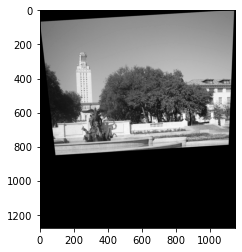

In [187]:
warped_img1 = warp_img(img1, H)
plt.imshow(warped_img1, cmap='gray')
# warped_img1 = warp_img(img1, H)


## 8. Create a new image to hold the panorama

In [197]:
def create_panorama(warped_img1, img2):
    # Determine dimensions needed for the panorama
    h1, w1 = warped_img1.shape[:2]
    h2, w2 = img2.shape[:2]

    # vertical offset of img2
    vertical_shift = 180  
    
    # start place of img2 based on the first image width
    overlap_shift = 450  

    # Calculate the width and height of the panorama
    height = max(h1, h2 + vertical_shift)
    width = w1 + w2 - overlap_shift  # Adjust width calculation for overlap

    # Create an empty panorama image
    panorama = np.zeros((height, width), dtype=warped_img1.dtype)

    # Place warped_img1 in the panorama
    panorama[:h1, :w1] = warped_img1

    # Blend img2 into the panorama
    panorama[vertical_shift:vertical_shift+h2, w1-overlap_shift:w1-overlap_shift+w2] = img2

    return panorama

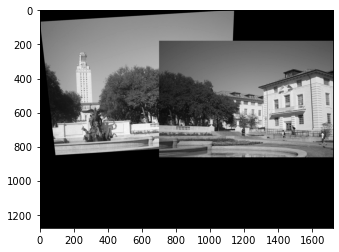

In [198]:
# create a panorama in gray scale first
panorama_gray = create_panorama(warped_img1, img2)
plt.imshow(panorama_gray, cmap='gray')

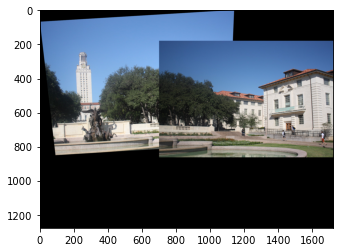

In [199]:
def create_panorama_rgb(img1, img2, H):
    # Determine channels needed for the panorama
    r1, g1, b1 = cv2.split(img1)
    r2, g2, b2 = cv2.split(img2)


    # Create panorama for each channel
    r_panorama = create_panorama(r1, r2)
    g_panorama = create_panorama(g1, g2)
    b_panorama = create_panorama(b1, b2)

    # Merge the channel panoramas back into one RGB image
    panorama_rgb = cv2.merge((r_panorama, g_panorama, b_panorama))
    return panorama_rgb

img1_color = skimage.io.imread("./uttower_left.jpg")
img1_color=warp_img(img1_color, H)
# print(f"size of img1{img1_color.shape}")
# plt.imshow(img1_color, cmap='gray')
img2_color = skimage.io.imread("./uttower_right.jpg")
panorama = create_panorama_rgb(img1_color, img2_color, H)
plt.imshow(panorama)